<a href="https://www.kaggle.com/code/vijay20213/loan-status-approved-not-95-accuracy?scriptVersionId=201855338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- Heading of the notebook with your template -->
<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FF8C00, #FFD700); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2);">
    <h1 style="color:black; font-family:Georgia, serif; font-size:32px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        🔍 Loan Status Prediction: Approved ✅ or Not ❌?
    </h1>
</div>

<!-- Table of Contents with your template -->
<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Table of Contents
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#Preprocessing-and-EDA" style="text-decoration:none; color:black;">1. Data Processing and EDA [Train Data]</a></li>
        <li><a href="#univariate-analysis" style="text-decoration:none; color:black;">2. Univariate Analysis [numerical data]</a></li>
        <li><a href="#data-preprocessing" style="text-decoration:none; color:black;">3. Label Encoding [categorical data]</a></li>
        <li><a href="#feature-engineering" style="text-decoration:none; color:black;">4. Processing Test data</a></li>
        <li><a href="#model-building" style="text-decoration:none; color:black;">5. Data Processing [Test Data]</a></li>
        <li><a href="#model-evaluation" style="text-decoration:none; color:black;">6. Model Training</a></li>        
        <li><a href="#model-evaluation" style="text-decoration:none; color:black;">6. Model Evaluation [Confusion Matrix]</a></li>
        <li><a href="#conclusion" style="text-decoration:none; color:black;">7. Submission</a></li>
    </ul>
</div>


<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Preprocessing and EDA
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#introduction" style="text-decoration:none; color:black;">1. Preprocessing</a></li>
        <li><a href="#data-overview" style="text-decoration:none; color:black;">2. EDA</a></li>
    </ul>
</div>

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


RUN_CNT = 0
MAIN_FOLDER = "/kaggle/input/playground-series-s4e10"
TEST = os.path.join(MAIN_FOLDER, 'test.csv')
TRAIN = os.path.join(MAIN_FOLDER, 'train.csv')

In [2]:
def IQR(train_df, column, range1, range2) -> pd.DataFrame:
    Q1 = train_df[column].quantile(range1)  
    Q3 = train_df[column].quantile(range2) 
    IQR = Q3 - Q1 

    print("Q1 = {}, Q3 = {}, IQR = {}".format(Q1, Q3, IQR))

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print("lower_bound = {}, upper_bound = {}".format(lower_bound, upper_bound))
    train_df_filtered = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    return train_df_filtered

def bar_plotter(df, column_name):

    plt.figure(figsize=(8, 6))
    sns.histplot(df[column_name], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()


def scatter(df, column):
    col = df[column]
    plt.scatter(x=list(range(len(col))), y=list(col), marker='.', color='red', alpha=0.2)
    plt.xlabel("Datapoint")
    plt.ylabel("frequemcy of person age")
    plt.show()
    
def outlier_remover(df, column, range1=0.22, range2=0.99) -> pd.DataFrame:
    scatter(df, column)
    final_df = IQR(df, column, range1=range1, range2=range2)
    print("Scatter after outlier removal")
    scatter(final_df, column)
    return final_df

def compare_series_barchart_compact(series1, series2, column_name):
    if series1.shape != series2.shape:
        raise ValueError("Series must have the same length")
    
    # Combine the series into a DataFrame for plotting
    df = pd.DataFrame({'DF1': series1, 'DF2': series2})
    
    # Melt the DataFrame to long format for plotting
    melted_df = df.reset_index().melt(id_vars='index', var_name='DataFrame', value_name='Values')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='index', y='Values', hue='DataFrame', data=melted_df, palette='tab10', dodge=True)
    
    # Adjust bar width and layout
    plt.title(f"train vs test dataset comparison with {column_name}")
    plt.xticks(rotation=45)
    plt.xlabel('Index')
    plt.tight_layout()
    plt.show()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Apply a dark background globally
plt.style.use('dark_background')

def IQR(train_df, column, range1, range2) -> pd.DataFrame:
    Q1 = train_df[column].quantile(range1)  
    Q3 = train_df[column].quantile(range2) 
    IQR = Q3 - Q1 

    print("Q1 = {}, Q3 = {}, IQR = {}".format(Q1, Q3, IQR))

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print("lower_bound = {}, upper_bound = {}".format(lower_bound, upper_bound))
    train_df_filtered = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    return train_df_filtered

def bar_plotter(df, column_name):
    plt.figure(figsize=(8, 6))
    sns.set_style("dark")
    sns.histplot(df[column_name], bins=30, kde=True, color='gray')  # Gray color for the plot
    plt.title(f'Distribution of {column_name}', color='gray')  # Gray title
    plt.xlabel(column_name, color='gray')  # Gray label
    plt.ylabel('Frequency', color='gray')  # Gray label
    plt.xticks(color='gray')  # Gray ticks
    plt.yticks(color='gray')  # Gray ticks
    plt.show()

def scatter(df, column):
    col = df[column]
    plt.scatter(x=list(range(len(col))), y=list(col), marker='.', color='gray', alpha=0.5)  # Gray color for points
    plt.xlabel("Datapoint", color='gray')  # Gray label
    plt.ylabel("Frequency of person age", color='gray')  # Gray label
    plt.xticks(color='gray')  # Gray ticks
    plt.yticks(color='gray')  # Gray ticks
    plt.show()

def outlier_remover(df, column, range1=0.22, range2=0.99) -> pd.DataFrame:
    scatter(df, column)
    final_df = IQR(df, column, range1=range1, range2=range2)
    print("Scatter after outlier removal")
    scatter(final_df, column)
    return final_df

def compare_series_barchart_compact(series1, series2, column_name):
    if series1.shape != series2.shape:
        raise ValueError("Series must have the same length")
    
    # Combine the series into a DataFrame for plotting
    df = pd.DataFrame({'DF1': series1, 'DF2': series2})
    
    # Melt the DataFrame to long format for plotting
    melted_df = df.reset_index().melt(id_vars='index', var_name='DataFrame', value_name='Values')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.set_style("dark")
    sns.barplot(x='index', y='Values', hue='DataFrame', data=melted_df, palette='gray', dodge=True)  # Gray palette
    
    # Adjust bar width and layout
    plt.title(f"Train vs Test Dataset Comparison with {column_name}", color='gray')
    plt.xlabel('Index', color='gray')
    plt.xticks(rotation=45, color='gray')  # Gray ticks
    plt.yticks(color='gray')  # Gray ticks
    plt.tight_layout()
    plt.show()


In [4]:
original_df_train = pd.read_csv(TRAIN)
train_df = original_df_train.applymap(lambda x: x + 0.00001 if x == 0 else x)
original_df_test = pd.read_csv(TEST)
test_df = original_df_test.applymap(lambda x: x + 0.00001 if x == 0 else x)
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.00001,37,35000,RENT,0.00001,EDUCATION,B,6000,11.49,0.17,N,14,0.00001
1,1.00000,22,56000,OWN,6.00000,MEDICAL,C,4000,13.35,0.07,N,2,0.00001
2,2.00000,29,28800,OWN,8.00000,PERSONAL,A,6000,8.90,0.21,N,10,0.00001
3,3.00000,30,70000,RENT,14.00000,VENTURE,B,12000,11.11,0.17,N,5,0.00001
4,4.00000,22,60000,RENT,2.00000,MEDICAL,A,6000,6.92,0.10,N,3,0.00001


<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> 📊 Preprocessing 📊</h2>


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  float64
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  float64
dtypes: float64(5), int64(4), object

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [7]:
train_df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701016,9217.556518,10.677874,0.159238,5.813556,0.142391
std,16929.497605,6.033216,3.793111e+04,3.959783,5563.807384,3.034697,0.091692,4.029196,0.349441
min,0.000010,20.000000,4.200000e+03,0.000010,500.000000,5.420000,0.000010,2.000000,0.000010
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000010
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000010
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000010
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [8]:
test_df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687070,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868393,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000010,700.000000,5.420000,0.000010,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [9]:
train_report = train_df.describe().drop(['id', 'loan_status'], axis='columns')
test_report = test_df.describe().drop(['id'], axis='columns')
test_report.index

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> 📊 Train Data vs Test Data 📊</h2>

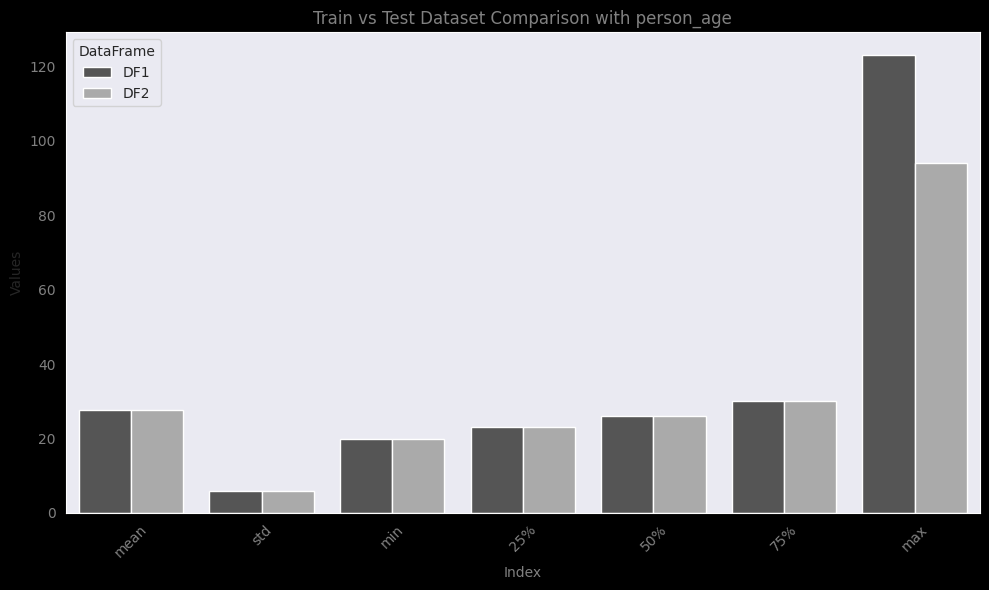

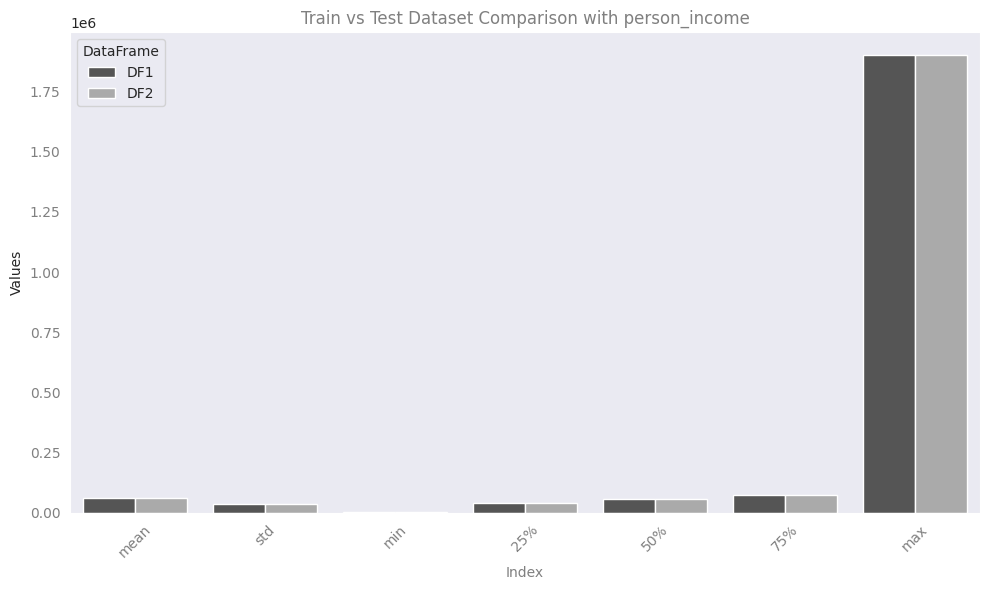

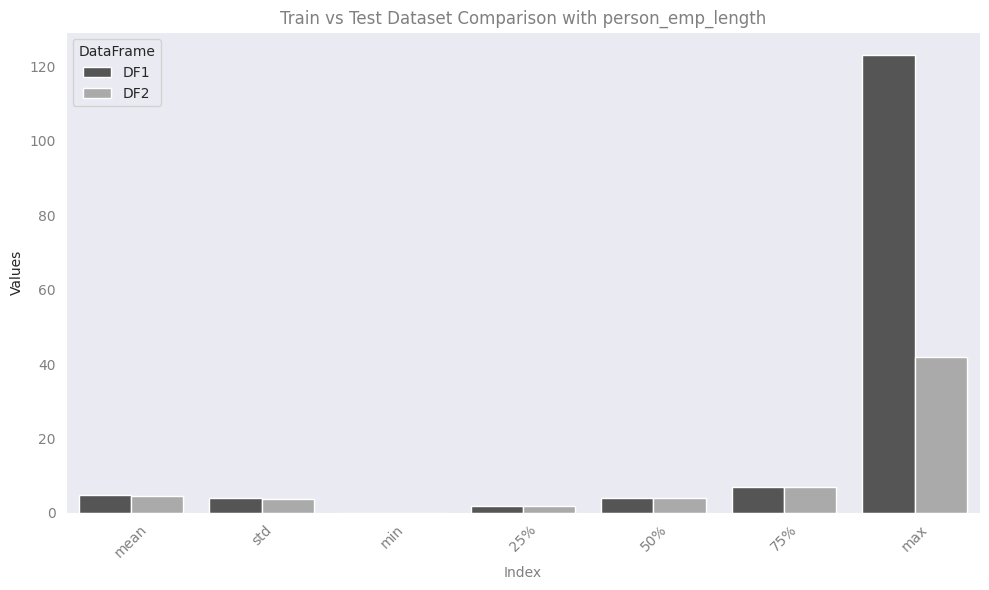

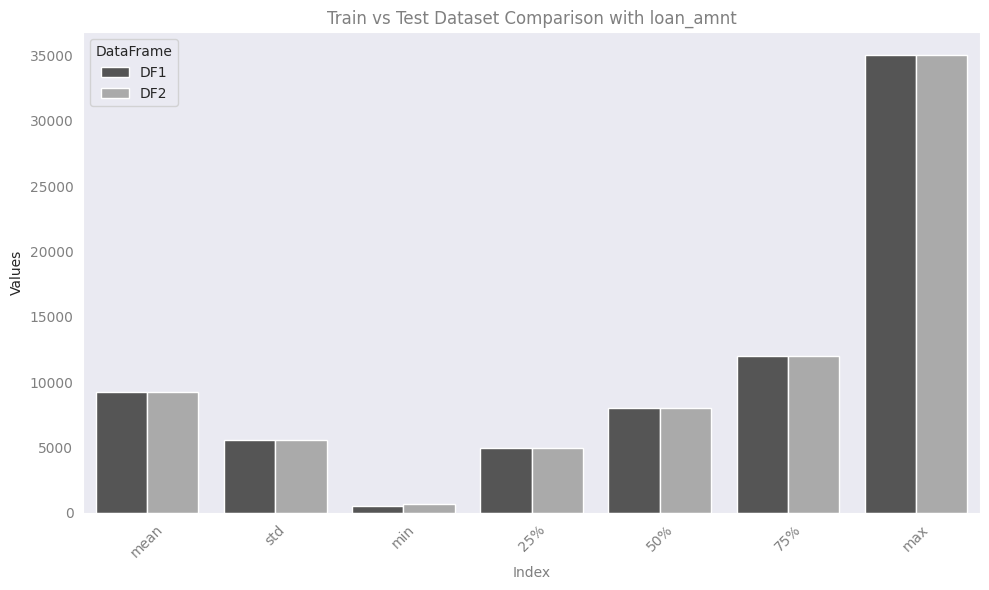

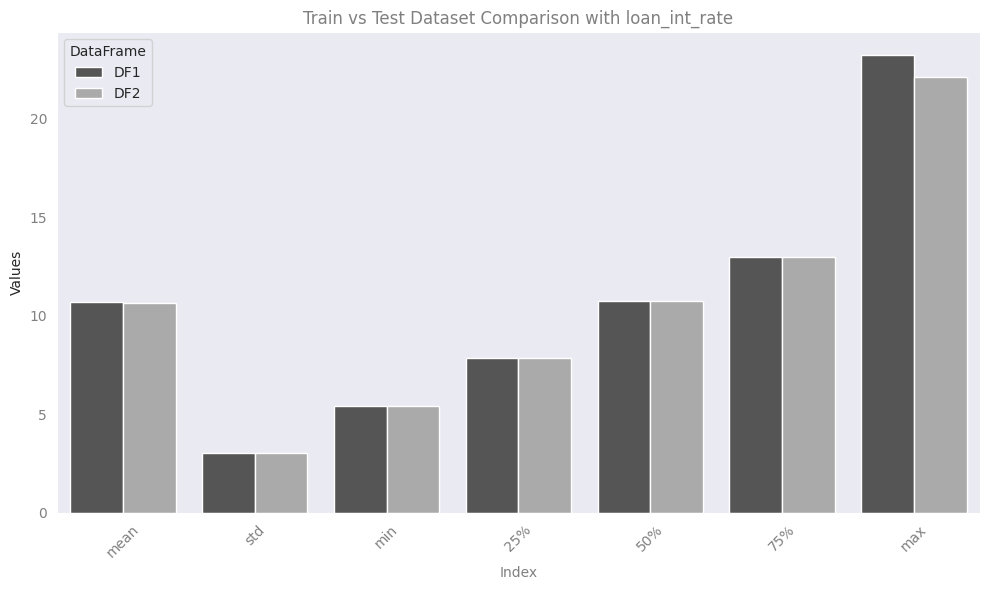

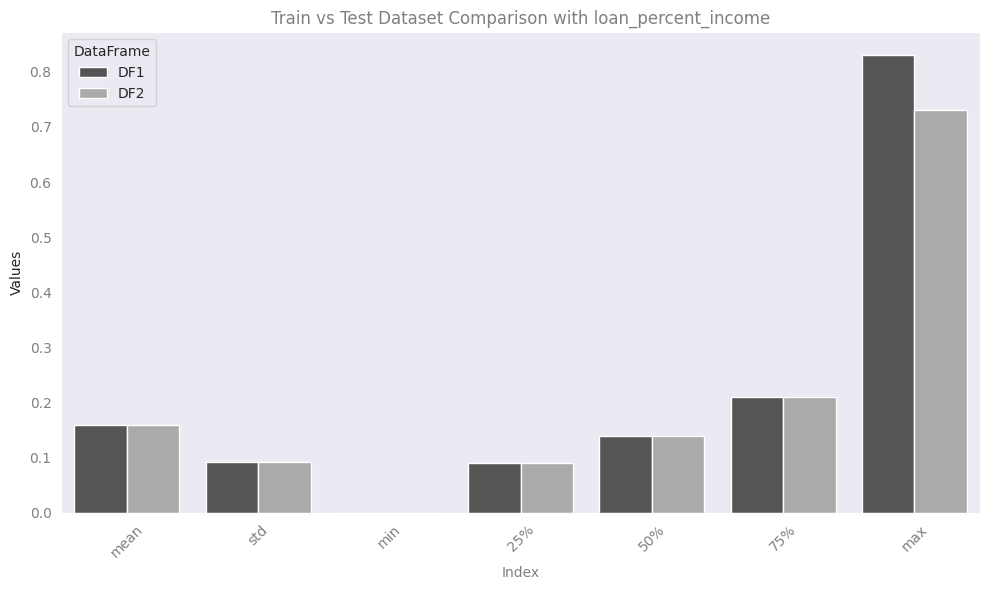

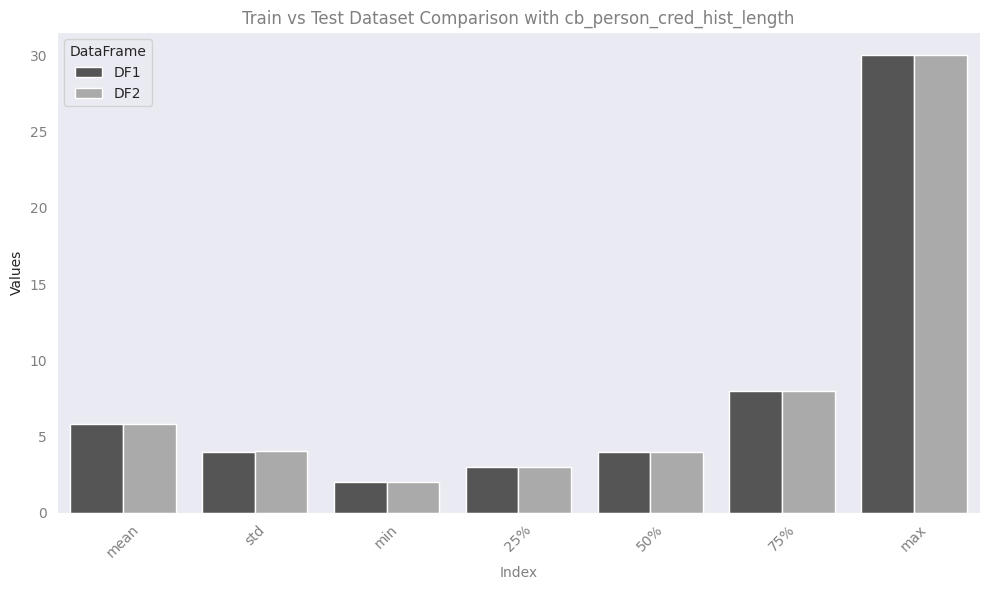

In [10]:
for row in train_report.columns:
    compare_series_barchart_compact(train_report[row][1:], test_report[row][1:], column_name=row)

## 

<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Univariate Analysis
    </h2>
    <ul style="font-size: 16px; color: #333333; line-height: 1.6; margin-left: 20px;">
    <li><strong>Outlier Detection:</strong> Identifying extreme values in the dataset that may skew model performance.</li>
    <li><strong>Log Transformation:</strong> Applying a logarithmic function to reduce skewness in data distribution.</li>
</ul>

</div>

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> 👥 Person Age Column 📊</h2>


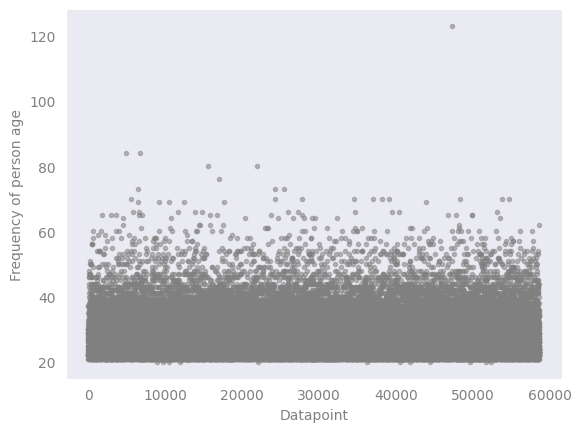

Q1 = 23.0, Q3 = 49.0, IQR = 26.0
lower_bound = -16.0, upper_bound = 88.0
Scatter after outlier removal


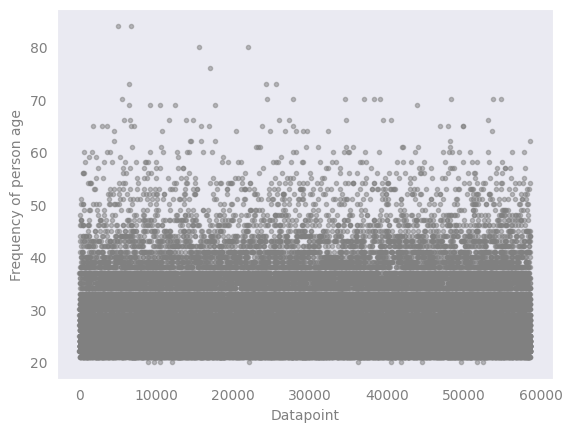

In [11]:
df1 = outlier_remover(train_df, 'person_age', 0.22, 0.99)

### Outlier Detection 

The Interquartile Range (IQR) is a measure of statistical dispersion that describes the spread of the middle 50% of a dataset. It is calculated as the difference between the third quartile (Q3) and the first quartile (Q1):

1. **First Quartile (Q1)**: The 25th percentile, meaning 25% of the data points fall below this value.
2. **Third Quartile (Q3)**: The 75th percentile, meaning 75% of the data points fall below this value.
3. **IQR Formula**:  
   \[
   \text{IQR} = Q3 - Q1
   \]

### Purpose:
- IQR is used to identify outliers, with values falling below \(Q1 - 1.5 \times \text{IQR}\) or above \(Q3 + 1.5 \times \text{IQR}\) considered as outliers.


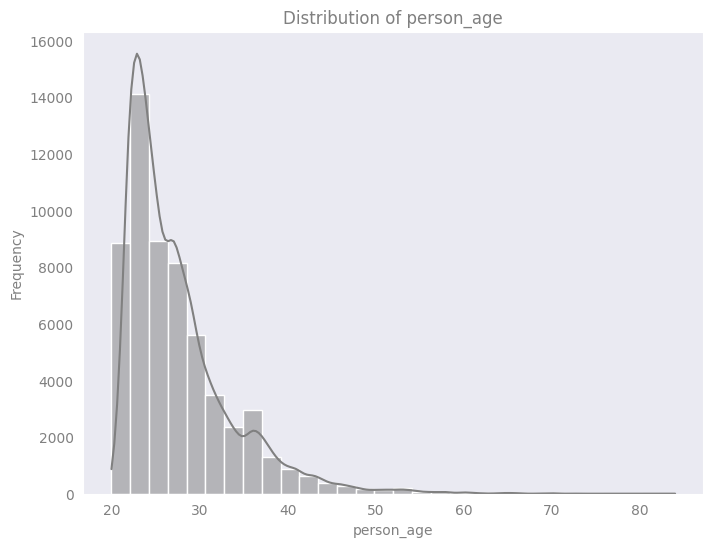

In [12]:
bar_plotter(df1, 'person_age')

### Right skewed data handling

To handle a right-skewed histogram, you can apply the following techniques:

1. **Log Transformation**: Apply `log(x)` to compress larger values and stretch smaller ones.
2. **Square Root Transformation**: Use `sqrt(x)` to reduce skewness.
3. **Reciprocal Transformation**: Apply `1/x` to handle extreme skewness.
4. **Power Transformation (Box-Cox)**: Use `scipy.stats.boxcox` to normalize the data.
5. **Binning**: Group data into intervals to reduce skewness.

These techniques help in making the distribution more symmetric for statistical analysis.

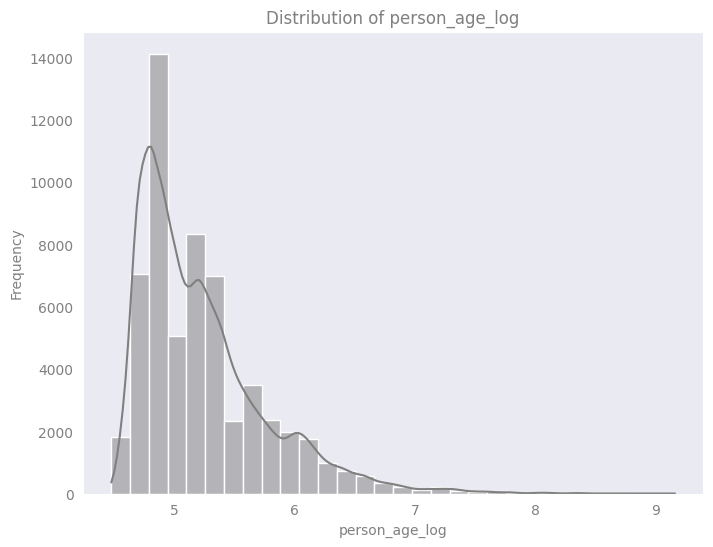

In [13]:
# square root
df1.loc[:,'person_age_log'] = df1['person_age'].apply(lambda x: np.sqrt(x))
bar_plotter(df=df1, column_name='person_age_log')

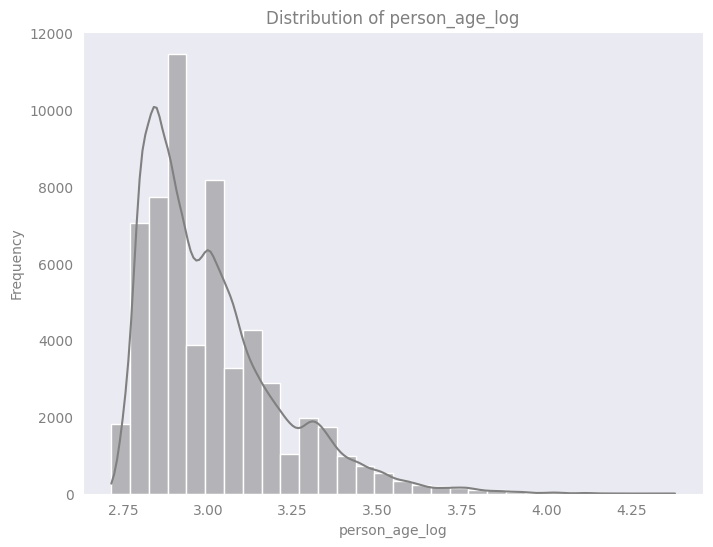

In [14]:
# cube root
df1.loc[:,'person_age_log'] = df1['person_age'].apply(lambda x: x**(1/3))
bar_plotter(df=df1, column_name='person_age_log')

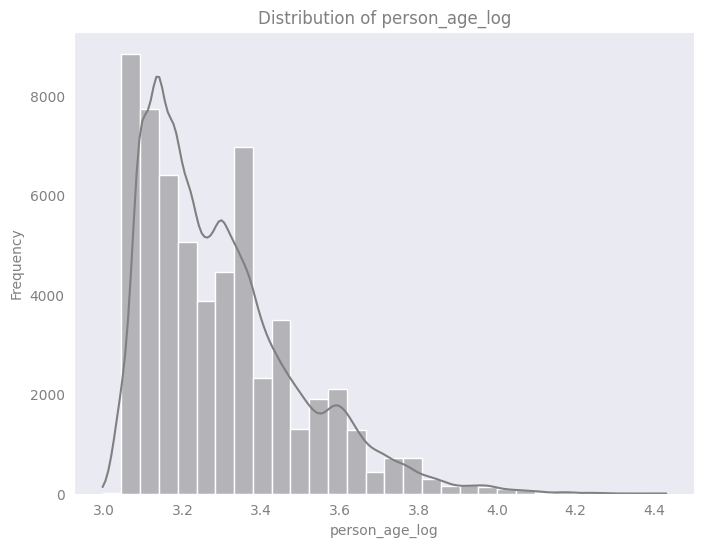

In [15]:
# log transformation"
df1.loc[:,'person_age_log'] = df1['person_age'].apply(lambda x: np.log(x))
bar_plotter(df=df1, column_name='person_age_log')

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> 👥 Person Income Column 📊</h2>


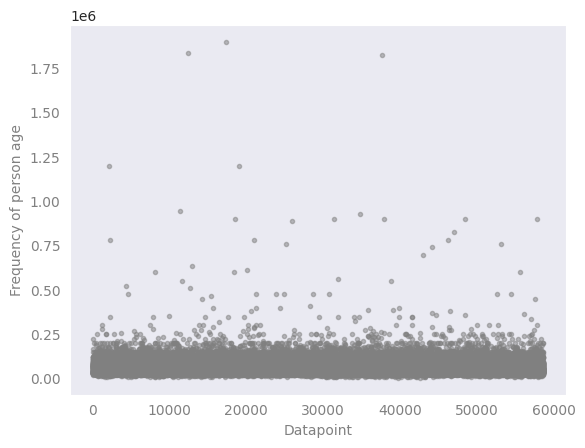

Q1 = 40000.0, Q3 = 175000.0, IQR = 135000.0
lower_bound = -162500.0, upper_bound = 377500.0
Scatter after outlier removal


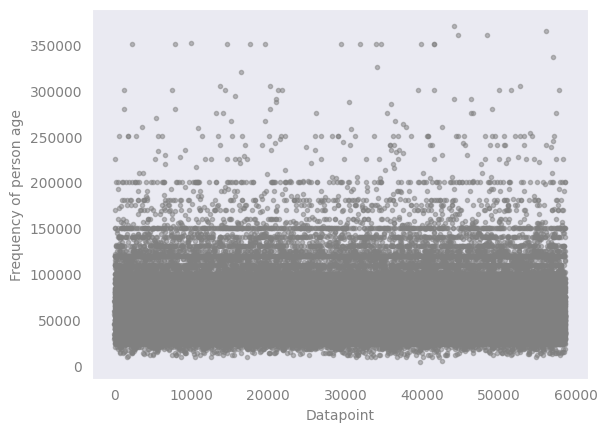

In [16]:
df2 = outlier_remover(df1, 'person_income')

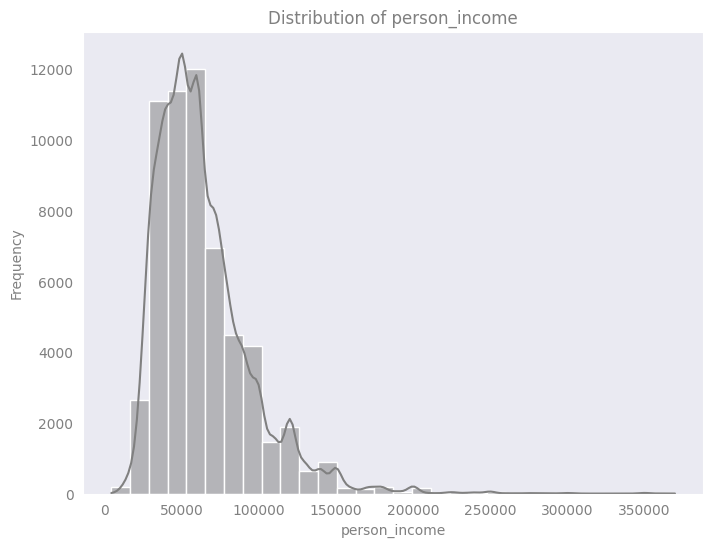

In [17]:
bar_plotter(df2, 'person_income')

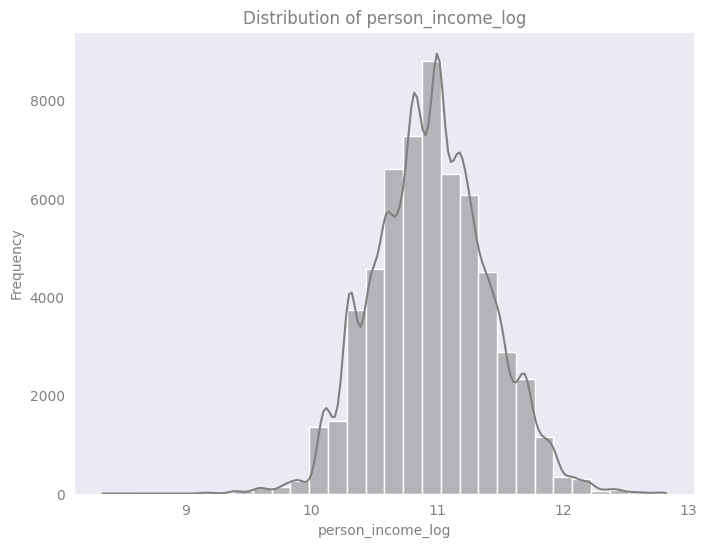

In [18]:
# log transformation
df2['person_income_log'] = df2['person_income'].apply(lambda x: np.log(x))
bar_plotter(df2, 'person_income_log')

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> person_emp_length column</h2>
<!-- Subheading template -->
<div style="background-color: #f0f8ff; border-left: 5px solid #4682B4; padding: 10px; margin: 15px 0;">
    <h2 style="font-size: 20px; color: #2F4F4F; font-family: 'Verdana', sans-serif;">
        Data Transformation Techniques
    </h2>
</div>

<!-- Bullet points -->
<ul style="font-size: 16px; color: #333333; line-height: 1.6; margin-left: 20px;">
    <li><strong>Outlier Detection:</strong> Identifying extreme values in the dataset that may skew model performance.</li>
    <li><strong>Log Transformation:</strong> Applying a logarithmic function to reduce skewness in data distribution.</li>
</ul>


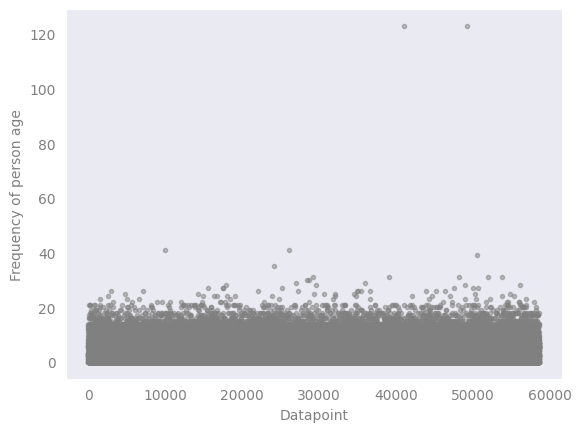

Q1 = 2.0, Q3 = 15.0, IQR = 13.0
lower_bound = -17.5, upper_bound = 34.5
Scatter after outlier removal


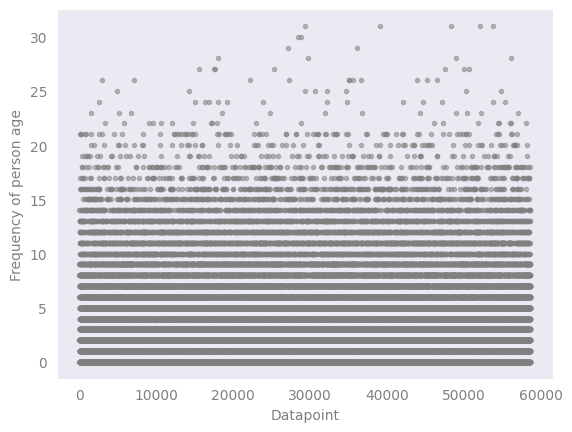

In [19]:
df3 = outlier_remover(df1, 'person_emp_length', 0.25, 0.98)

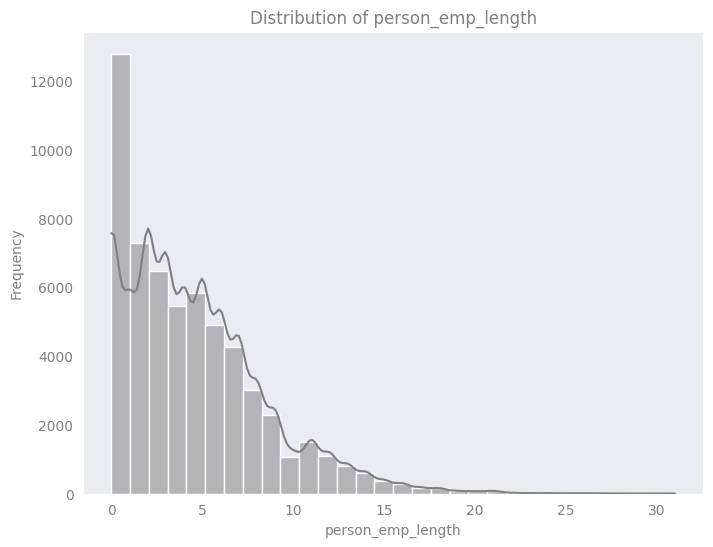

In [20]:
bar_plotter(df3, 'person_emp_length')

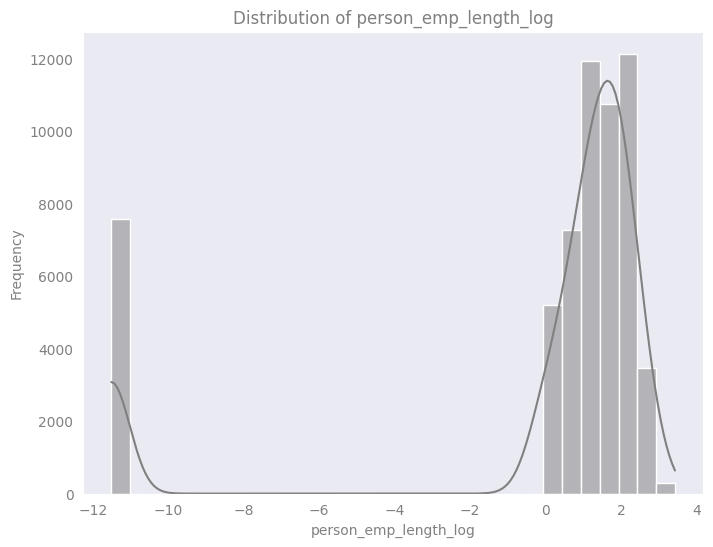

In [21]:
# log transformation
df3['person_emp_length_log'] = df3['person_emp_length'].apply(lambda x: np.log(x))
bar_plotter(df3, 'person_emp_length_log')

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> loan amount column</h2>

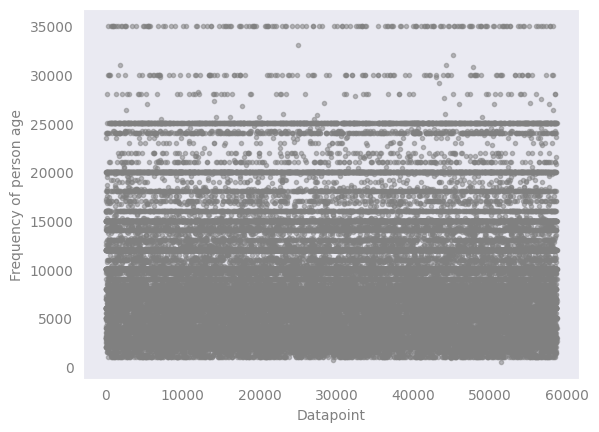

Q1 = 5000.0, Q3 = 25000.0, IQR = 20000.0
lower_bound = -25000.0, upper_bound = 55000.0
Scatter after outlier removal


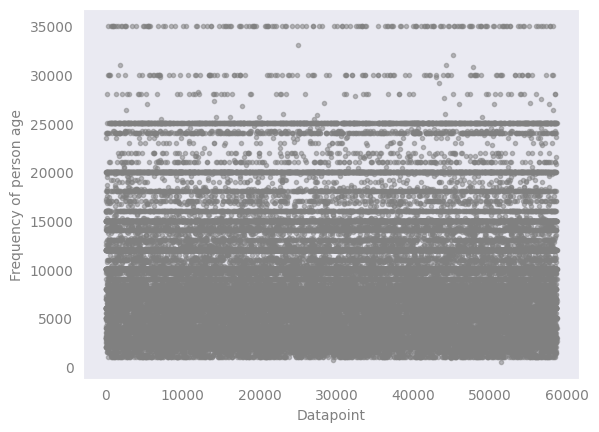

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_age_log,person_emp_length_log
0,0.00001,37,35000,RENT,0.00001,EDUCATION,B,6000,11.49,0.17,N,14,0.00001,3.610918,-11.512925
1,1.00000,22,56000,OWN,6.00000,MEDICAL,C,4000,13.35,0.07,N,2,0.00001,3.091042,1.791759
2,2.00000,29,28800,OWN,8.00000,PERSONAL,A,6000,8.90,0.21,N,10,0.00001,3.367296,2.079442
3,3.00000,30,70000,RENT,14.00000,VENTURE,B,12000,11.11,0.17,N,5,0.00001,3.401197,2.639057
4,4.00000,22,60000,RENT,2.00000,MEDICAL,A,6000,6.92,0.10,N,3,0.00001,3.091042,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640.00000,34,120000,MORTGAGE,5.00000,EDUCATION,D,25000,15.95,0.21,Y,10,0.00001,3.526361,1.609438
58641,58641.00000,28,28800,RENT,0.00001,MEDICAL,C,10000,12.73,0.35,N,8,1.00000,3.332205,-11.512925
58642,58642.00000,23,44000,RENT,7.00000,EDUCATION,D,6800,16.00,0.15,N,2,1.00000,3.135494,1.945910
58643,58643.00000,22,30000,RENT,2.00000,EDUCATION,A,5000,8.90,0.17,N,3,0.00001,3.091042,0.693147


In [22]:
outlier_remover(df3, 'loan_amnt', 0.25, 0.99)

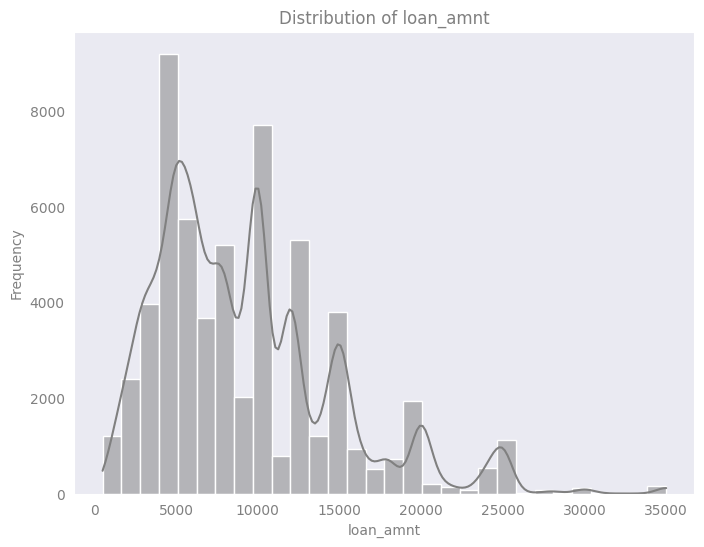

In [23]:
bar_plotter(df3, 'loan_amnt')

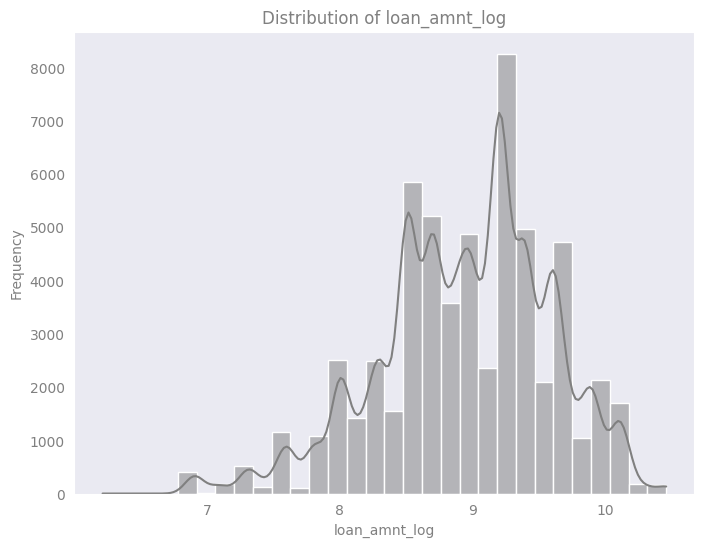

In [24]:
# log transformation 
df3['loan_amnt_log'] = df3['loan_amnt'].apply(lambda x: np.log(x))
bar_plotter(df3, 'loan_amnt_log')

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> loan_int_rate column</h2>


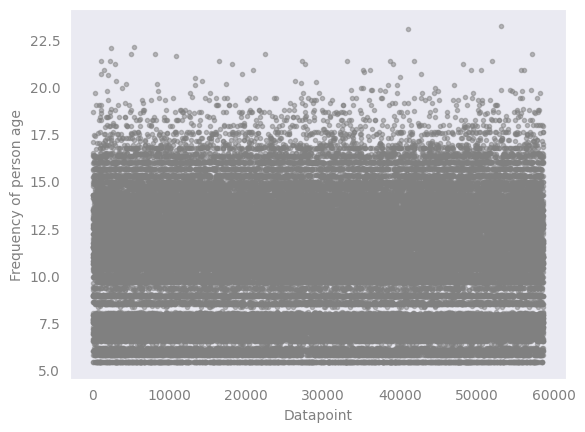

Q1 = 7.88, Q3 = 12.99, IQR = 5.11
lower_bound = 0.21499999999999897, upper_bound = 20.655
Scatter after outlier removal


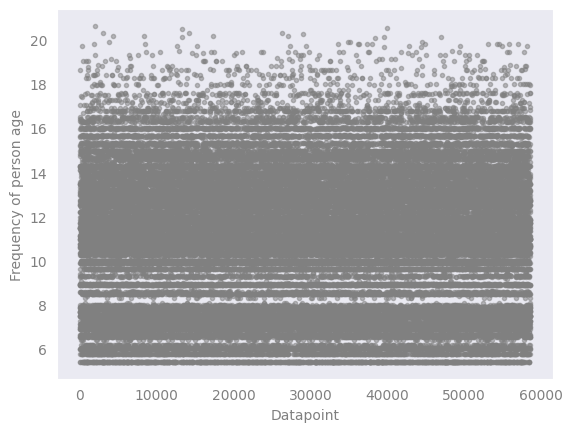

In [25]:
df4 = outlier_remover(df3, 'loan_int_rate', 0.25, 0.75)

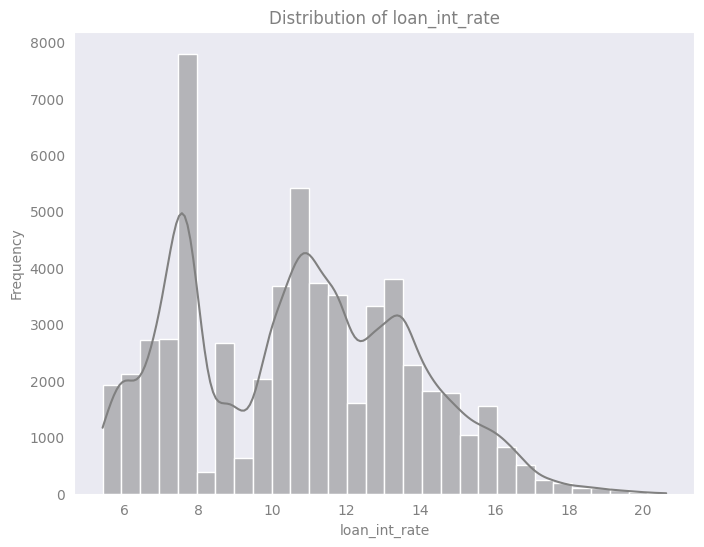

In [26]:
bar_plotter(df4, 'loan_int_rate')


<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> loan_percent_income column</h2>


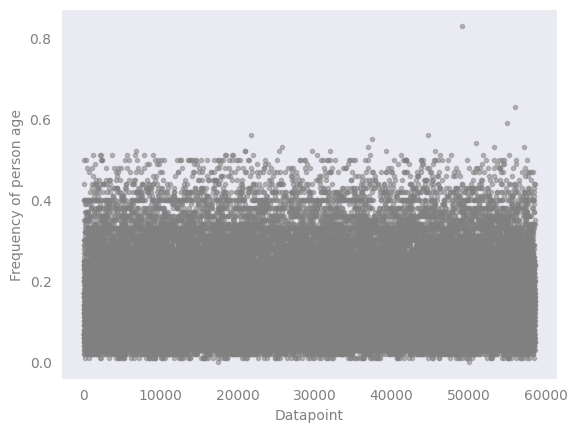

Q1 = 0.09, Q3 = 0.25, IQR = 0.16
lower_bound = -0.15, upper_bound = 0.49
Scatter after outlier removal


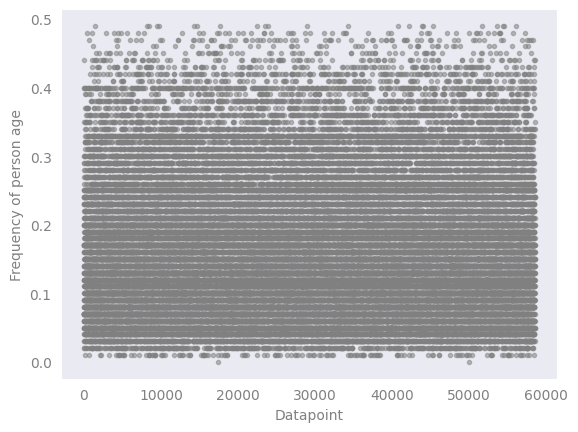

In [27]:
df5 = outlier_remover(df4, 'loan_percent_income', 0.25, 0.85)

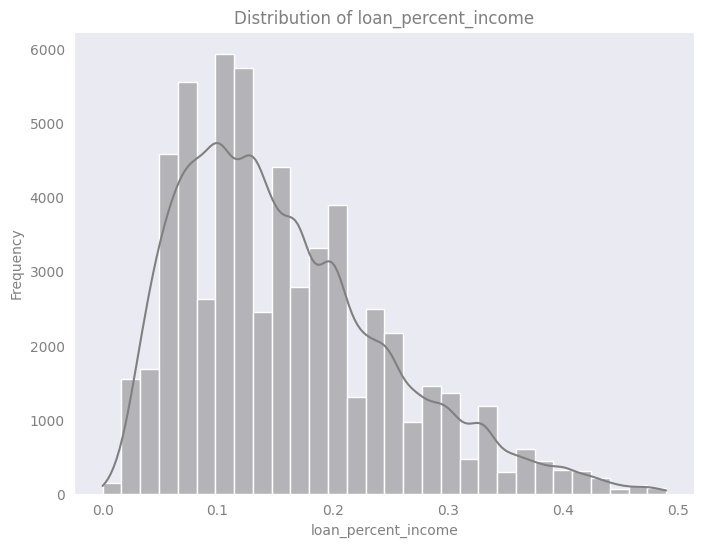

In [28]:
bar_plotter(df5, 'loan_percent_income')

<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> cb_person_cred_hist_length column</h2>

<!-- Subheading template -->
<div style="background-color: #f0f8ff; border-left: 5px solid #4682B4; padding: 10px; margin: 15px 0;">
    <h2 style="font-size: 20px; color: #2F4F4F; font-family: 'Verdana', sans-serif;">
        Data Transformation Techniques
    </h2>
</div>

<!-- Bullet points -->
<ul style="font-size: 16px; color: #333333; line-height: 1.6; margin-left: 20px;">
    <li><strong>Outlier Detection:</strong> Identifying extreme values in the dataset that may skew model performance.</li>
    </ul>


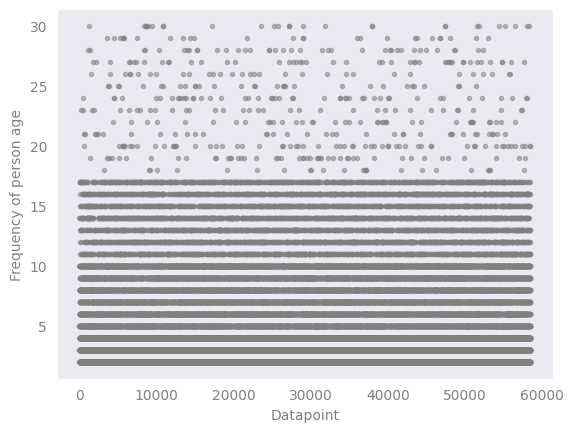

Q1 = 3.0, Q3 = 10.0, IQR = 7.0
lower_bound = -7.5, upper_bound = 20.5
Scatter after outlier removal


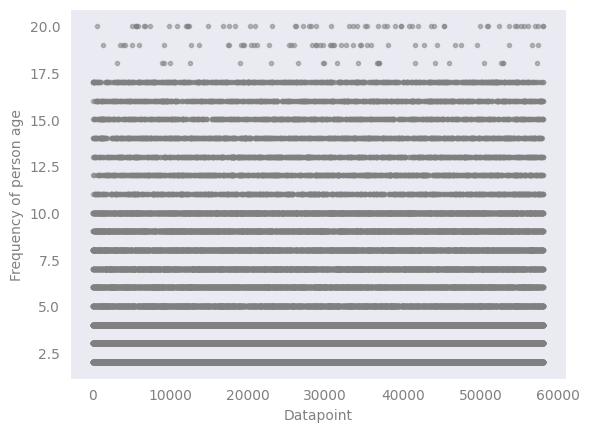

In [29]:
df6 = outlier_remover(df5, 'cb_person_cred_hist_length', 0.25, 0.85)

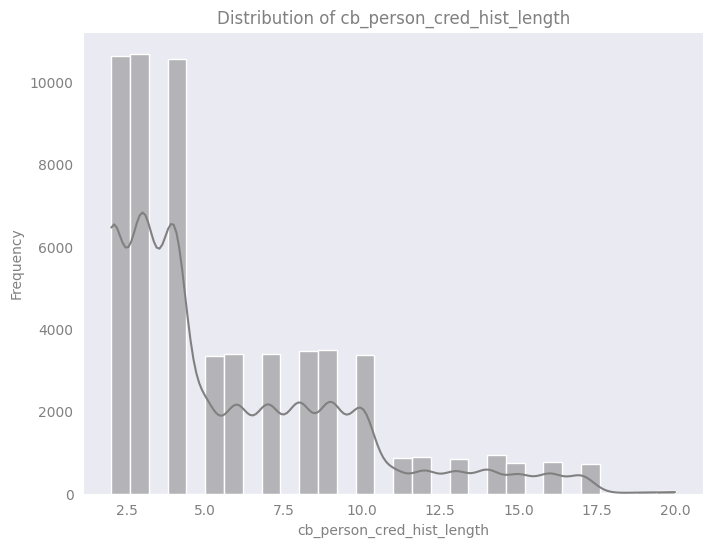

In [30]:
bar_plotter(df6, 'cb_person_cred_hist_length')

In [31]:
original_df_train.shape[0] - df6.shape[0]

513

<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Categorical Column [Label Encoding]
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#introduction" style="text-decoration:none; color:black;">1. Label Encoding</a></li>
    </ul>
</div>

In [32]:
cat_columns = ['loan_intent','loan_grade','cb_person_default_on_file','person_home_ownership']

for col in cat_columns:
    print(f"{col} Unique values = ", df6[col].unique())

loan_intent Unique values =  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
loan_grade Unique values =  ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file Unique values =  ['N' 'Y']
person_home_ownership Unique values =  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']


In [33]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in cat_columns:
    df6.loc[:,col+"_en"] = encoder.fit_transform(df6[col])
df6.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_age_log,person_emp_length_log,loan_amnt_log,loan_intent_en,loan_grade_en,cb_person_default_on_file_en,person_home_ownership_en
0,0.00001,37,35000,RENT,0.00001,EDUCATION,B,6000,11.49,0.17,N,14,0.00001,3.610918,-11.512925,8.699515,1,1,0,3
1,1.00000,22,56000,OWN,6.00000,MEDICAL,C,4000,13.35,0.07,N,2,0.00001,3.091042,1.791759,8.294050,3,2,0,2
2,2.00000,29,28800,OWN,8.00000,PERSONAL,A,6000,8.90,0.21,N,10,0.00001,3.367296,2.079442,8.699515,4,0,0,2
3,3.00000,30,70000,RENT,14.00000,VENTURE,B,12000,11.11,0.17,N,5,0.00001,3.401197,2.639057,9.392662,5,1,0,3
4,4.00000,22,60000,RENT,2.00000,MEDICAL,A,6000,6.92,0.10,N,3,0.00001,3.091042,0.693147,8.699515,3,0,0,3


In [34]:
updated_columns = ['person_age_log','person_emp_length_log','loan_amnt_log','loan_intent_en','loan_grade_en','cb_person_default_on_file_en','person_home_ownership_en']
original_columns = ['_'.join(val.split('_')[:-1]) for val in updated_columns]

# removing source columns
df7 = df6.drop(original_columns, axis='columns')
df7.head()

,id,person_income,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_age_log,person_emp_length_log,loan_amnt_log,loan_intent_en,loan_grade_en,cb_person_default_on_file_en,person_home_ownership_en
0,0.00001,35000,11.49,0.17,14,0.00001,3.610918,-11.512925,8.699515,1,1,0,3
1,1.00000,56000,13.35,0.07,2,0.00001,3.091042,1.791759,8.294050,3,2,0,2
2,2.00000,28800,8.90,0.21,10,0.00001,3.367296,2.079442,8.699515,4,0,0,2
3,3.00000,70000,11.11,0.17,5,0.00001,3.401197,2.639057,9.392662,5,1,0,3
4,4.00000,60000,6.92,0.10,3,0.00001,3.091042,0.693147,8.699515,3,0,0,3


In [35]:
df7['loan_status_up'] = df7['loan_status'].apply(lambda x: int(x))
df8 = df7.copy()

df8['loan_status'] = df8['loan_status_up']

if 'loan_status_up' in df8.columns:
    df8.drop('loan_status_up', axis = 'columns', inplace=True)

df8.head()

,id,person_income,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_age_log,person_emp_length_log,loan_amnt_log,loan_intent_en,loan_grade_en,cb_person_default_on_file_en,person_home_ownership_en
0,0.00001,35000,11.49,0.17,14,0,3.610918,-11.512925,8.699515,1,1,0,3
1,1.00000,56000,13.35,0.07,2,0,3.091042,1.791759,8.294050,3,2,0,2
2,2.00000,28800,8.90,0.21,10,0,3.367296,2.079442,8.699515,4,0,0,2
3,3.00000,70000,11.11,0.17,5,0,3.401197,2.639057,9.392662,5,1,0,3
4,4.00000,60000,6.92,0.10,3,0,3.091042,0.693147,8.699515,3,0,0,3


In [36]:
df8.shape, original_df_train.shape

((58132, 13), (58645, 13))

In [37]:
def post_remover(val):
    if '_log' in val:
        val = val.replace('_log','')
    elif "_en" in val:
        val = val.replace('_en','')
    return val

input_columns = [post_remover(val) for val in df8.columns]
input_columns

['id',
 'person_income',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_status',
 'person_age',
 'person_emp_length',
 'loan_amnt',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'person_home_ownership']

In [38]:
for c1,c2 in zip(input_columns, df8.columns):
    if c1 not in c2:
        print(c1, c2)
        print("Not matched")

In [39]:
df8.columns = input_columns
df8.head()

,id,person_income,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_age,person_emp_length,loan_amnt,loan_intent,loan_grade,cb_person_default_on_file,person_home_ownership
0,0.00001,35000,11.49,0.17,14,0,3.610918,-11.512925,8.699515,1,1,0,3
1,1.00000,56000,13.35,0.07,2,0,3.091042,1.791759,8.294050,3,2,0,2
2,2.00000,28800,8.90,0.21,10,0,3.367296,2.079442,8.699515,4,0,0,2
3,3.00000,70000,11.11,0.17,5,0,3.401197,2.639057,9.392662,5,1,0,3
4,4.00000,60000,6.92,0.10,3,0,3.091042,0.693147,8.699515,3,0,0,3


<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Data Processing [Test Data]
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#introduction" style="text-decoration:none; color:black;">1. Label Encoding</a></li>
        <li><a href="#data-overview" style="text-decoration:none; color:black;">2. Log Transformation</a></li>
    </ul>
</div>

In [40]:
num_cols, cat_cols = original_columns[:3], original_columns[3:]
num_cols, cat_cols

(['person_age', 'person_emp_length', 'loan_amnt'],
 ['loan_intent',
  'loan_grade',
  'cb_person_default_on_file',
  'person_home_ownership'])

In [41]:
test_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [42]:
if 'id' in test_df.columns:
    test_df = test_df.drop('id', axis='columns')

In [43]:
test_df.shape, df8.shape

((39098, 11), (58132, 13))

In [44]:
test_df_log = test_df[num_cols]
test_df_en = test_df[cat_cols]
test_remain = test_df.drop(num_cols+cat_cols, axis='columns')

In [45]:
test_df_log_up = test_df_log.applymap(lambda x: np.log(x))
test_df_log_up.head()

,person_age,person_emp_length,loan_amnt
0,3.135494,1.098612,10.126631
1,3.258097,1.791759,9.210340
2,3.258097,1.609438,8.294050
3,3.496508,1.386294,8.853665
4,3.258097,2.079442,9.615805


In [46]:
for col in cat_cols:
    test_df_en.loc[:,col] = encoder.fit_transform(test_df_en[col])
test_df_en.head()

,loan_intent,loan_grade,cb_person_default_on_file,person_home_ownership
0,2,5,0,3
1,4,2,1,0
2,5,4,1,3
3,0,0,0,3
4,2,3,1,0


In [47]:
final_test_df = pd.concat([test_df_log_up, test_df_en, test_remain], axis='columns')
final_test_df.head()

,person_age,person_emp_length,loan_amnt,loan_intent,loan_grade,cb_person_default_on_file,person_home_ownership,person_income,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,3.135494,1.098612,10.126631,2,5,0,3,69000,15.76,0.36,2
1,3.258097,1.791759,9.210340,4,2,1,0,96000,12.68,0.10,4
2,3.258097,1.609438,8.294050,5,4,1,3,30000,17.19,0.13,2
3,3.496508,1.386294,8.853665,0,0,0,3,50000,8.90,0.14,7
4,3.258097,2.079442,9.615805,2,3,1,0,102000,16.32,0.15,4


In [48]:
final_test_df.shape

(39098, 11)

In [49]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  float64
 1   person_emp_length           39098 non-null  float64
 2   loan_amnt                   39098 non-null  float64
 3   loan_intent                 39098 non-null  object 
 4   loan_grade                  39098 non-null  object 
 5   cb_person_default_on_file   39098 non-null  object 
 6   person_home_ownership       39098 non-null  object 
 7   person_income               39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.3+ MB


In [50]:
X = df8.drop(['id','loan_status'], axis='columns').columns
y = ['loan_status']

In [51]:
last_one = final_test_df[X]
                        
last_one.head()

,person_income,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_age,person_emp_length,loan_amnt,loan_intent,loan_grade,cb_person_default_on_file,person_home_ownership
0,69000,15.76,0.36,2,3.135494,1.098612,10.126631,2,5,0,3
1,96000,12.68,0.10,4,3.258097,1.791759,9.210340,4,2,1,0
2,30000,17.19,0.13,2,3.258097,1.609438,8.294050,5,4,1,3
3,50000,8.90,0.14,7,3.496508,1.386294,8.853665,0,0,0,3
4,102000,16.32,0.15,4,3.258097,2.079442,9.615805,2,3,1,0


In [52]:
df8.head()

,id,person_income,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_age,person_emp_length,loan_amnt,loan_intent,loan_grade,cb_person_default_on_file,person_home_ownership
0,0.00001,35000,11.49,0.17,14,0,3.610918,-11.512925,8.699515,1,1,0,3
1,1.00000,56000,13.35,0.07,2,0,3.091042,1.791759,8.294050,3,2,0,2
2,2.00000,28800,8.90,0.21,10,0,3.367296,2.079442,8.699515,4,0,0,2
3,3.00000,70000,11.11,0.17,5,0,3.401197,2.639057,9.392662,5,1,0,3
4,4.00000,60000,6.92,0.10,3,0,3.091042,0.693147,8.699515,3,0,0,3


<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Model Training
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#introduction" style="text-decoration:none; color:black;">1. Hyperparameter Tuning [Grid Search CV]</a></li>
        <li><a href="#data-overview" style="text-decoration:none; color:black;">2. Model Training</a></li>    
    </ul>
</div>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df8.drop(['loan_status', 'id'], axis='columns'), df8['loan_status'], stratify=df8['loan_status'], shuffle=True)

model = RandomForestClassifier()
model.fit(X_train, y_train)
"Train score", model.score(X_train, y_train), "Test score", model.score(X_test, y_test)

('Train score', 0.9999541273882429, 'Test score', 0.9490814009495631)

In [54]:
from sklearn.metrics import accuracy_score, classification_report

def train_and_predict(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)

    train_score = classifier.score(X_train, y_train)
    test_score = accuracy_score(y_test, predictions)

    print(f"Model: {classifier.__class__.__name__}")
    print(f"Training Score: {train_score:.4f}")
    print(f"Testing Score: {test_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    return classifier, predictions


classifiers = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    GaussianNB()
]

for classifier in classifiers:
    print(f'Using classifier: {classifier.__class__.__name__}')
    trained_model, predictions = train_and_predict(classifier, X_train, X_test, y_train, y_test)
    print("\n" + "-" * 50 + "\n")


Using classifier: LogisticRegression
Model: LogisticRegression
Training Score: 0.8593
Testing Score: 0.8594

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     12489
           1       0.00      0.00      0.00      2044

    accuracy                           0.86     14533
   macro avg       0.43      0.50      0.46     14533
weighted avg       0.74      0.86      0.79     14533


--------------------------------------------------

Using classifier: SVC
Model: SVC
Training Score: 0.8593
Testing Score: 0.8594

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     12489
           1       0.00      0.00      0.00      2044

    accuracy                           0.86     14533
   macro avg       0.43      0.50      0.46     14533
weighted avg       0.74      0.86      0.79     14533


--------------------------------------------------

Using 


<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> Grid Search CV</h2>


In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 120, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, 
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

print("Best parameters for RandomForestClassifier:")
print(rf_grid_search.best_params_)
print("Best training score:", rf_grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for RandomForestClassifier:
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best training score: 0.9499988583405848



<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> Model Training</h2>


In [56]:
best_params = {
    'max_depth': 30,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 200
}
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9496


In [57]:
sub_model = RandomForestClassifier(**best_params)
sub_model.fit(df8.drop(['loan_status', 'id'], axis='columns'), df8['loan_status'])
result = sub_model.predict(last_one)
print(len(result), test_df.shape)

39098 (39098, 11)



<h2 style="font-size: 18px; color: green; text-align: right; font-style: italic;">----> Model Evaluation </h2>


<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Model Evaluation
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#introduction" style="text-decoration:none; color:black;">1. Confusion Matrix</a></li>
        <li><a href="#data-overview" style="text-decoration:none; color:black;">2. Classification Report</a></li>    
    </ul>
</div>

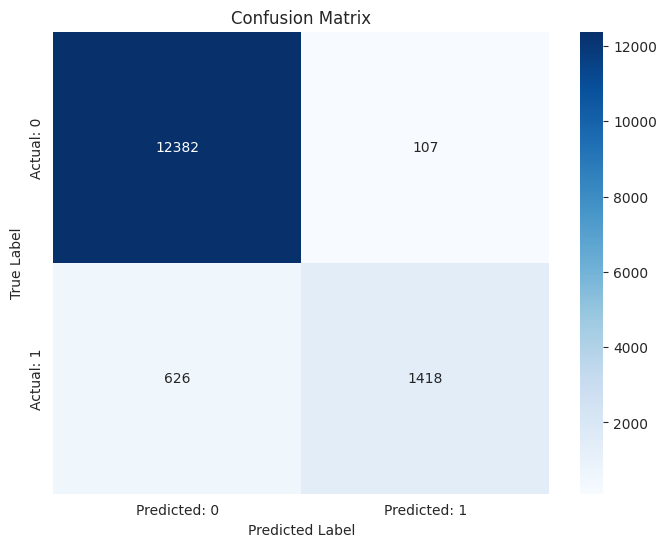

In [58]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: 0', 'Predicted: 1'], 
            yticklabels=['Actual: 0', 'Actual: 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()


In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12489
           1       0.93      0.69      0.79      2044

    accuracy                           0.95     14533
   macro avg       0.94      0.84      0.88     14533
weighted avg       0.95      0.95      0.95     14533



In [60]:
import joblib
joblib.dump(final_model, "loan_status.pkl")

['loan_status.pkl']

<div style="border: none; padding: 15px; border-radius: 12px; background: linear-gradient(135deg, #FFD700, #FF8C00); box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.2); margin-top: 20px;">
    <h2 style="color:black; font-family:Georgia, serif; font-size:26px; text-align:center; text-shadow: 2px 2px 4px rgba(255, 255, 255, 0.5);">
        📋 Submission
    </h2>
    <ul style="font-size: 1.2em; line-height: 1.8; padding-left: 20px;">
        <li><a href="#introduction" style="text-decoration:none; color:black;">1. Confusion Matrix</a></li>
        <li><a href="#data-overview" style="text-decoration:none; color:black;">2. Classification Report</a></li>    
    </ul>
</div>

In [61]:
final = pd.concat([original_df_test['id'] , pd.DataFrame(result)], axis='columns')
final.columns = ['id', 'loan_status']
final.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0


In [62]:
final.to_csv("loan_status_submission_2.csv", index=False)
print("Collected submissions")

Collected submissions
